In [1]:
using StatsBase,Distributions,NamedArrays

seed = "NA" # seed for repeated initial conditions
#srand(seed)
 
cur_dir = pwd()

const n_hosts = 5                      # number of hosts
const n_microbes = 100                # number of individuals (microbes) per host
const n_microbial_species = 10         # number of species
const host_reproduction = true          # do hosts also reproduce? "false" corresponds to the standard neutral model
const host_generation_time = 100     # generation time of hosts
const n_initial_colonizers = 5          # how many microbial species colonize a host from the environment?
    # what fraction of the microbiome is inherited?
const m = 0.01                            # immigration probability of the neutral model

const t_max = 5e6                   # how long does the simulation run

const reproduction_additivity = true   # multiple bacteria of the effector type will keep affecting reproduction if true. If this is true reproduction impact should be very low.
const reproduction_impact = 1.      #(alpha_r) Impact of the reproduction in the selection [value between -1 and 1]
const effector_microbe = 1              # which microbe has an effect in the host

1

In [2]:
# function takes a range of species and their distribution in an environment and returns a microbiome
function colonize_from_environment(species::Array{Int64}, n_microbes::Int64, environment::Array{Float64}, n_colonizers::Int64)
    microbiome = zeros(Int64,length(species))

    init_species = wsample(species, environment, n_colonizers)
    for i = 1:length(init_species)-1
        if n_microbes - sum(microbiome) > 1
            microbiome[init_species[i]] += sample(1:n_microbes - sum(microbiome))
        end
    end
    microbiome[init_species[length(init_species)]] += n_microbes - sum(microbiome)

    return microbiome
end

# function takes the impact of one strain, if this impact is additive, the index of this strain and the state of the system and returns a weight vector
function set_host_weight_vector(effect_value::Float64,additivity::Bool, effector_microbe::Int64,hosts_matrix::Array{Int64,2})
        new_n_hosts = size(hosts_matrix)[2]

        effector_microbes_per_host_w =  effect_value > 0 ? hosts_matrix[effector_microbe,:] : n_microbes - hosts_matrix[effector_microbe,:]
        total_effectors_w = sum(effector_microbes_per_host_w)

        if sum(total_effectors_w) > 0    #This condition is for the case where there are no effector microbes.
            effect_type = additivity == true ? effector_microbes_per_host_w :  effector_microbes_per_host_w .!= 0
            abs_effect_value = abs(effect_value)
            hosts_weight_vector = (1. / new_n_hosts) * (1. - abs_effect_value) + abs_effect_value * (effect_type / total_effectors_w )
        else
            hosts_weight_vector = ones(new_n_hosts) / new_n_hosts
        end

    return hosts_weight_vector
end

set_host_weight_vector (generic function with 1 method)

In [3]:
# define array of the species (basically just a list 0, ..., n)
microbial_species = [Int(i) for i=1:n_microbial_species];
otu_id = ["OTU " * string(i) for i in microbial_species];

# define the source community of the neutral model
effector_in_source = 0.1
source_community =[(1-effector_in_source)/(n_microbial_species-1) for i=1:n_microbial_species]; #We force the source to be homogeneous
source_community[effector_microbe] = effector_in_source
source_community
#source_community = 1.0*source_community/sum(source_community)

10-element Array{Float64,1}:
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1

In [4]:
function sim_herit_var(herit)
# function that runs the simulation
    
    # define the hosts
    hosts = Matrix{Int64}(n_microbial_species,n_hosts)
    host_vec = Vector{Int64}(n_hosts)
    host_id = Array{String,1}(n_hosts)
    tmp_host_matrix = Matrix{Int64}(n_microbial_species,n_hosts)
    
    for host_num=1:n_hosts
        hosts[:,host_num] = colonize_from_environment(microbial_species, n_microbes, source_community, n_initial_colonizers)
        host_vec[host_num] = host_num
        host_id[host_num] = "Host " * string(host_num)
    end

    
    microbiome_heritability = herit
    for t = 1:t_max

        # host reproduction
        if host_reproduction && t % host_generation_time == 0

            # pick the new set of hosts with the probabilities of the previous
            parents_vector = reproduction_impact == 0 ? sample(host_vec,n_hosts): wsample(host_vec,
            set_host_weight_vector(reproduction_impact,reproduction_additivity,effector_microbe,hosts),n_hosts)

            for new_id in host_vec
                # determine microbiome for new host as weighted sum of environmental and ancestral microbes
                env_sample = 1.0*colonize_from_environment(microbial_species, n_microbes, source_community, n_initial_colonizers)/n_microbes  
            inherited_microbes = wsample(microbial_species, (1.0*microbiome_heritability*hosts[:,parents_vector[new_id]]/n_microbes + (1 - microbiome_heritability)*env_sample),n_microbes)

                tmp_host_matrix[:,new_id] = zeros(Int,n_microbial_species)
                for species in inherited_microbes
                    tmp_host_matrix[species,new_id] += 1
                end
            end

        hosts = copy(tmp_host_matrix)
        end


        # microbial reproduction
        for host_index= 1:n_hosts
            # death
            hosts[wsample(microbial_species, 1.0*hosts[:,host_index]/n_microbes),host_index] -= 1
            # birth
            hosts[wsample(microbial_species, (m*source_community + (1-m)*hosts[:,host_index]/(n_microbes-1))),host_index] += 1
        end

    end
    return hosts
end

sim_herit_var (generic function with 1 method)

# function that runs the simulation
    
    # define the hosts
    hosts = Matrix{Int64}(n_microbial_species,n_hosts)
    host_vec = Vector{Int64}(n_hosts)
    host_id = Array{String,1}(n_hosts)
    tmp_host_matrix = Matrix{Int64}(n_microbial_species,n_hosts)
    
    for host_num=1:n_hosts
        hosts[:,host_num] = colonize_from_environment(microbial_species, n_microbes, source_community, n_initial_colonizers)
        host_vec[host_num] = host_num
        host_id[host_num] = "Host " * string(host_num)
    end

    host_ov_time = Matrix{Int64}(Int(t_max),n_hosts)
    microbiome_heritability = 0.9
    for t = 1:t_max

        # host reproduction
        if host_reproduction && t % host_generation_time == 0

            # pick the new set of hosts with the probabilities of the previous
            parents_vector = reproduction_impact == 0 ? sample(host_vec,n_hosts): wsample(host_vec,
            set_host_weight_vector(reproduction_impact,reproduction_additivity,effector_microbe,hosts),n_hosts)

            for new_id in host_vec
                # determine microbiome for new host as weighted sum of environmental and ancestral microbes
                env_sample = 1.0*colonize_from_environment(microbial_species, n_microbes, source_community, n_initial_colonizers)/n_microbes  
            inherited_microbes = wsample(microbial_species, (1.0*microbiome_heritability*hosts[:,parents_vector[new_id]]/n_microbes + (1. - microbiome_heritability)*env_sample),n_microbes)

                tmp_host_matrix[:,new_id] = zeros(Int,n_microbial_species)
                for species in inherited_microbes
                    tmp_host_matrix[species,new_id] += 1
                end
            end

        hosts = copy(tmp_host_matrix)
        end


        # microbial reproduction
        for host_index= 1:n_hosts
            # death
            hosts[wsample(microbial_species, 1.0*hosts[:,host_index]/n_microbes),host_index] -= 1
            # birth
            hosts[wsample(microbial_species, (m*source_community + (1-m)*hosts[:,host_index]/(n_microbes-1))),host_index] += 1
        end
    host_ov_time[Int(t),:] = hosts[effector_microbe,:]
end

using DataFrames,Gadfly

means = mapslices(mean,host_ov_time,2)
stds = mapslices(std,host_ov_time,2)
df_sym = DataFrame(
Time = 1:t_max,
means = means[:],
stds = stds[:],
ymin = means[:] .- stds[:],
ymax = means[:] .+ stds[:]#,
#Simulation= repeat(,inner=tot_time)
) 

p = plot(df_sym, 
    x=:Time, y=:means, 
    ymin=:ymin, ymax=:ymax, 
    Geom.line, Geom.ribbon)

In [5]:
herit_range = 0:0.1:1
reps = 3

out_data = Array{Int64,3}(reps,length(herit_range),n_hosts)

for i in 1:length(herit_range)
    println("Herit: ",herit_range[i])
    for rep in 1:reps
        out_data[rep,i,:] = sim_herit_var(herit_range[i])[1,:]
        println(out_data[rep,i,:])
    end
end

Herit: 0.0
[0,0,0,0,68]
[14,0,1,43,0]
[0,0,69,5,10]
Herit: 0.1
[0,15,17,22,1]
[7,2,82,1,2]
[2,1,4,6,0]
Herit: 0.2
[1,21,20,37,20]
[4,2,17,47,6]
[59,78,14,1,89]
Herit: 0.3
[15,56,20,35,27]
[12,6,11,71,5]
[10,3,6,14,8]
Herit: 0.4
[13,13,8,6,17]
[0,4,4,5,2]
[13,28,16,9,35]
Herit: 0.5
[48,23,10,14,10]
[6,48,20,12,9]
[5,20,5,13,3]
Herit: 0.6
[17,9,21,29,10]
[40,54,51,24,16]
[15,18,25,27,9]
Herit: 0.7
[32,28,43,10,33]
[41,23,22,28,28]
[34,19,31,34,18]
Herit: 0.8
[27,24,51,51,36]
[7,22,19,16,26]
[7,15,11,21,0]
Herit: 0.9
[56,44,41,26,30]
[53,28,41,38,33]
[33,44,46,47,34]
Herit: 1.0
[100,100,100,100,100]
[94,100,100,96,100]
[100,98,100,99,98]


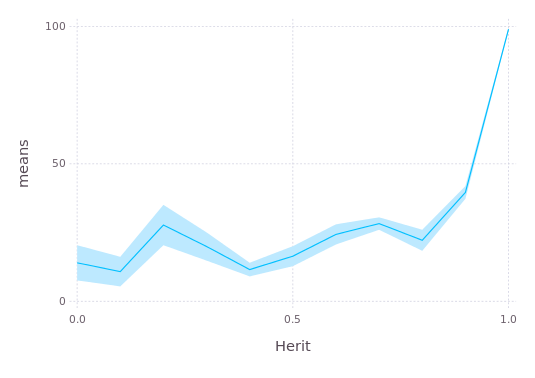

In [6]:
using DataFrames,Gadfly

means = mapslices(mean,out_data,(1,3))[:]
stds = mapslices(std,out_data,(1,3))[:]
df_sym = DataFrame(
Herit = herit_range,
means = means[:],
stds = stds[:],
ymin = means[:] .- stds[:]/sqrt(n_hosts*reps),
ymax = means[:] .+ stds[:]/sqrt(n_hosts*reps)#,
#Simulation= repeat(,inner=tot_time)
) 

p = plot(df_sym, 
    x=:Herit, y=:means, 
    ymin=:ymin, ymax=:ymax, 
    Geom.line, Geom.ribbon)

In [7]:
draw(SVG("Herit_Sen.svg",30cm,30cm),p)

false